# Global Sea Surface Temperature Trends

**Objective: Calculate Global Rates of Change, Highlight Regions of Specific Percentiles.**

## Product 3: Global Change Rate Netcdfs, Percentile Rankings

Steps for calculating change rates across netcdf files can be found here: http://atedstone.github.io/rate-of-change-maps/. The desired end result is a map with the global OISST extent that displays the sea surface temperature warming rate of each cell. Depending on how difficult/time-consuming that is to generate a second variable ranking the warming rates will also be added. In this way areas can be highlighted by how rapidly they are warming relative to other areas on the planet.

In [1]:
import xarray as xr
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import numpy as np
import netCDF4
import os

# Set the workspace - local/ docker
workspace = "local"

# Root paths
root_locations = {"local"  : "/Users/akemberling/Box/",
                  "docker" : "/home/jovyan/"}


# Set root
box_root = root_locations[workspace]
print(f"Working via {workspace} directory at: {box_root}")


#Suppress divide by NA error that occurs when getting mean from array
np.seterr(divide = 'ignore', invalid = 'ignore')
np.seterr(divide = 'ignore', invalid = 'ignore')

Working via local directory at: /Users/akemberling/Box/


{'divide': 'ignore', 'over': 'warn', 'under': 'ignore', 'invalid': 'ignore'}

Regional differences in sea surface temperature change-rates are important for management considerations surrounding ecosystem resiliency around climate change. An important step in this process is mapping out what the change rates are globally.

### Loading the OISST Files:

First step is to get everything loaded, so step one is to load in all the yearly oisst data files. The files all have the same naming convention so we just need to iterate through the available years to generate a list of all the files.

**NOTE:** Most recent year may need to be excluded as it is not a complete year. An alternative could be to weight the years by their number of days.

In [2]:
#Generate list of file names from start and end + 1
start_year = 1982
end_year = 2020
end_year = end_year + 1
my_years = np.arange(start_year, end_year, 1)
nc_files = []
for i in my_years:
    nc_files.append(f"{box_root}RES_Data/OISST/oisst_mainstays/annual_observations/sst.day.mean." + str(i) + ".v2.nc")
    

Once all the file names are generated they can be loaded as a single object using xarray's open_mfdataset(). These observations are currently on a daily time step. That will need to be fixed to compute annual warming rates.

In [3]:
# Open the OISSt Files
oisst = xr.open_mfdataset(nc_files, parallel = False, combine = "by_coords")

# Get Annual Averages

Having an annual rate of change rather than a daily rate of change does two things for us. Its a more tangible rate for comparison, and it makes computation take a great deal less time.

/Users/akemberling/opt/anaconda2/envs/py36/lib/python3.6/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


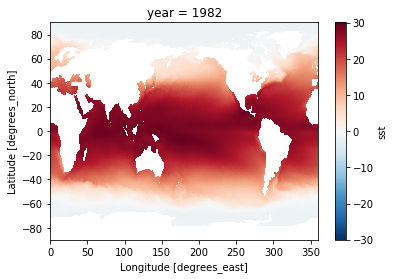

In [4]:
year_avg = oisst.groupby('time.year').mean()
year_avg['sst'].sel(year = 1982).plot()

## Calculating Trends

In [ ]:
# Pull arrays of the sea surface temperatures and the time dimensions
vals = year_avg.sst.values
years = year_avg.year.values

# Reshape to an array with as many rows as years and as many columns as there are pixels
vals2 = vals.reshape(len(years), -1)

# Do a first-degree polyfit (i.e. a line)
regressions = np.polyfit(years, vals2, 1)

# Get the coefficients back
trends = regressions[0, :].reshape(vals.shape[1], vals.shape[2])

/Users/akemberling/opt/anaconda2/envs/py36/lib/python3.6/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


Re-format the numpy array to an xarray dataarray, do some plotting for verification.

Text(0.5, 1.0, 'Annual Warming Rates - By Pixel')

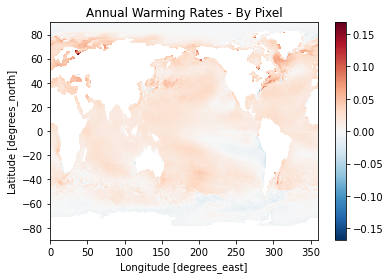

In [162]:
# convert to xarray, rename dimensions, get coordinates from original
trend_xr = xr.DataArray(trends).rename({"dim_0" : "lat", "dim_1" : "lon"}).assign_coords(lon = oisst.coords["lon"], lat = oisst.coords["lat"])

In [10]:
# What is going on with the regressions array?
regressions.shape
# 2 x ncells. First vakue is regression coefficients

(2, 1036800)

# Next Steps:

 - Get the percentiles of these warming rate values
 - Put these warming rates & their percentiles into a DataArrayDataset 
 - Pull lat/lon dimensions from original, apply attributes and metadata that details start/end date
 - Export Somewhere
 
`trends` is still a numpy array so first step is to get the percentiles of those values
`np.percentile` can be used to return distinct quantile breaks from the data:

I think what would be better is to rank them and divide by the number of ranks for a continuous scale 0-1

In [200]:
# source: https://stackoverflow.com/questions/5284646/rank-items-in-an-array-using-python-numpy-without-sorting-array-twice

#### 1. Copy the trend values so we can change them without impacting originals
trends_rank = trends.copy()


#### 2. Get the values and their matching indices

# # Weird idea, but as a way to flag NAS we can set them to an obnoxiously low value, then using the total number of NA's 
# # Just count the true rank as beginning after the known NAs
# total_nas = len(trends_rank[np.isnan(trends_rank)])
# total_nas

# # or replace nan values
# min_rate = trends_nona.min()
# trends_rank[np.isnan(trends_rank)] = min_rate - .05
# xr.DataArray(trends_rank).plot()


#### 3. drop the NA values
# pull array of just non-nan values
trends_nona = trends_rank[~np.isnan(trends_rank)]


# order + rank them
order = trends_nona.argsort()
rank = order.argsort()

#scale by max rank to get percentiles
max_rank = rank.max()
rank_norm = rank / max_rank
rank_norm

# Replace the non-NA values in trends_rank with the scaled ranks
order_out = trends_rank.copy()
order_out[~np.isnan(rank_out)] = order
rank_out = trends_rank.copy()
rank_out[~np.isnan(rank_out)] = rank_norm


#### 4. Original Code - NA's included in rank... bad:


# Argsort returns the indices that would sort the array
# ordering those indices returns their rank
#.argsort(axis = 1) #row by row for multi-dimensional arrays

#order = trends_rank.argsort(axis=1)
#rank = order.argsort(axis=1)


## Re-format to xarray Datasets

Before combining everything just reformat to the final form and do some plotting to make sure everything makes sense.

In [201]:
# We now have 2 more arrays, one with the order, the other with their ranks
order_xr = xr.DataArray(order_out).rename({"dim_0" : "lat", "dim_1" : "lon"}).assign_coords(lon = oisst.coords["lon"], lat = oisst.coords["lat"])
rank_xr  = xr.DataArray(rank_out).rename({"dim_0" : "lat", "dim_1" : "lon"}).assign_coords(lon = oisst.coords["lon"], lat = oisst.coords["lat"])


## Map everything for visual check

My understanding of python is a little shaky so at a bare minimum the warming rate map should have same visual patterns as their rankings.

Text(0.5, 1.0, 'Annual Warming Rates - By Pixel')

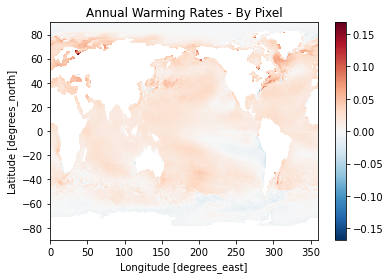

In [202]:
trend_xr.plot()
plt.title("Annual Warming Rates - By Pixel")

Text(0.5, 1.0, 'Warming Rate Rankings')

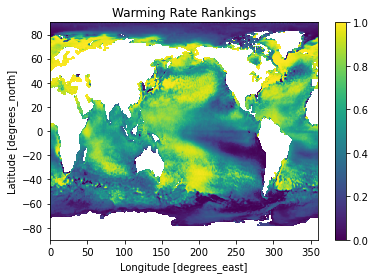

In [199]:
rank_xr.plot() #not good! NA values should not have a rank...
plt.title("Warming Rate Rankings")

## Adding Trends and Ranks back into xr.Dataset

We now have arrays of matching dimensions to the orginal oisst data indicating their warming rates as well as their rankings. We want to now assemble them into a single xarray dataset with the proper lat/lon dimensions and attributes relaying important metadata.

In [225]:
# Make it an xarray Dataset
trends_ds = trend_xr.to_dataset(name = "annual_warming_rate")
trends_ds

<xarray.Dataset>
Dimensions:              (lat: 720, lon: 1440)
Coordinates:
  * lon                  (lon) float32 0.125 0.375 0.625 ... 359.625 359.875
  * lat                  (lat) float32 -89.875 -89.625 -89.375 ... 89.625 89.875
Data variables:
    annual_warming_rate  (lat, lon) float64 nan nan nan ... -0.003083 -0.003083

In [226]:
# Assign the warming rate percentiles as another variable
trends_ds = trends_ds.assign(rate_percentile = rank_xr)

In [227]:
# Identify top 25%
#trends_ds['rate_percentile']
trends_ds.rate_percentile > .75

<xarray.DataArray 'rate_percentile' (lat: 720, lon: 1440)>
array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])
Coordinates:
  * lon      (lon) float32 0.125 0.375 0.625 0.875 ... 359.375 359.625 359.875
  * lat      (lat) float32 -89.875 -89.625 -89.375 ... 89.375 89.625 89.875

Text(0.5, 1.0, 'Warming Rates in top 80.0% - By Pixel')

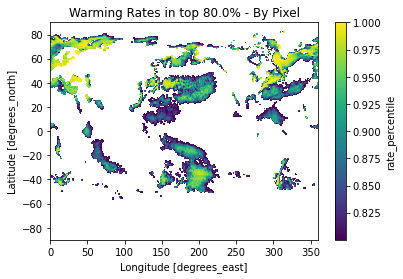

In [232]:
# Plot top x%
x_percentile = .80
trends_ds.where(trends_ds.rate_percentile > x_percentile).rate_percentile.plot()
plt.title(f"Warming Rates in top {x_percentile * 100}% - By Pixel")

# Adding Metadata

May need to do it both for the rates and for the ranks, but lets just see...

In [230]:
trends_ds.attrs

{}

In [231]:
#Change the Attributes for the dataset
trends_ds.attrs['title']         = 'Annual sea surface temperature warming rates from NOAA OISSTv2 SST Data'
trends_ds.attrs['institution']   = 'Gulf of Maine Research Institute'
trends_ds.attrs['source']        = 'NOAA/NCDC  ftp://eclipse.ncdc.noaa.gov/pub/OI-daily-v2/'
trends_ds.attrs['comment']       = 'Sea surface temperature averaged by year prior to use in linear regression for warming rates. Warming rates processed at level of individual pixels. Warming rate percentile is the ranking of low-high warming rate of an individual cell divided by total number of cells ranked to range 0-1.'
trends_ds.attrs['history']       = 'Warming rates calculated 11/19/2020'
trends_ds.attrs['references']    = 'https://www.esrl.noaa.gov/psd/data/gridded/data.noaa.oisst.v2.highres.html'
trends_ds.attrs['dataset_title'] = 'GMRI Sea Surface Warming Rates and Rankings - OISST'
trends_ds.attrs

{'title': 'Annual sea surface temperature warming rates from NOAA OISSTv2 SST Data',
 'institution': 'Gulf of Maine Research Institute',
 'source': 'NOAA/NCDC  ftp://eclipse.ncdc.noaa.gov/pub/OI-daily-v2/',
 'comment': 'Sea surface temperature averaged by year prior to use in linear regression for warming rates. Warming rates processed at level of individual pixels. Warming rate percentile is the ranking of low-high warming rate of an individual cell divided by total number of cells ranked to range 0-1.',
 'history': 'Warming rates calculated 11/19/2020',
 'references': 'https://www.esrl.noaa.gov/psd/data/gridded/data.noaa.oisst.v2.highres.html',
 'dataset_title': 'GMRI Sea Surface Warming Rates and Rankings - OISST'}

In [240]:
# And again for the warming rate data?
trends_ds.annual_warming_rate.attrs['long_name']   = "Annual Sea Surface Temperature Warming Rate"
trends_ds.annual_warming_rate.attrs['units']       = "degC"
trends_ds.annual_warming_rate.attrs['valid_range'] = "array([-2., 2.], dtype=float32)"
trends_ds.annual_warming_rate.attrs['dataset']     = "NOAA High-resolution Blended Analysis"
trends_ds.annual_warming_rate.attrs['var_desc']    = "Sea Surface Temperature"
trends_ds.annual_warming_rate.attrs['level_desc']  = "Surface"
trends_ds.annual_warming_rate.attrs['statistic']   = "Mean"
trends_ds.annual_warming_rate.attrs['parent_stat'] = "Mean Annual Sea Surface Temperature"
trends_ds.annual_warming_rate.attrs

{'long_name': 'Annual Sea Surface Temperature Warming Rate',
 'units': 'degC',
 'valid_range': 'array([-2., 2.], dtype=float32)',
 'dataset': 'NOAA High-resolution Blended Analysis',
 'var_desc': 'Sea Surface Temperature',
 'level_desc': 'Surface',
 'statistic': 'Mean',
 'parent_stat': 'Mean Annual Sea Surface Temperature'}

In [241]:
# And again for the warming rate ranks?
trends_ds.rate_percentile.attrs['long_name']   = "Annual Sea Surface Temperature Warming Rate Rank"
trends_ds.rate_percentile.attrs['units']       = "Percentile"
trends_ds.rate_percentile.attrs['valid_range'] = "array([0., 1.], dtype=float32)"
trends_ds.rate_percentile.attrs['dataset']     = "NOAA High-resolution Blended Analysis"
trends_ds.rate_percentile.attrs['var_desc']    = "Sea Surface Temperature"
trends_ds.rate_percentile.attrs['level_desc']  = "Surface"
trends_ds.rate_percentile.attrs['statistic']   = "Rank Percentile"
trends_ds.rate_percentile.attrs['parent_stat'] = "Annual Sea Surface Temperature Warming Rates"
trends_ds.rate_percentile.attrs

{'long_name': 'Annual Sea Surface Temperature Warming Rate Rank',
 'units': 'Percentile',
 'valid_range': 'array([0., 1.], dtype=float32)',
 'dataset': 'NOAA High-resolution Blended Analysis',
 'var_desc': 'Sea Surface Temperature',
 'level_desc': 'Surface',
 'statistic': 'Rank Percentile',
 'parent_stat': 'Annual Sea Surface Temperature Warming Rates'}

# Exporting the Netcdf

In [243]:
#trends_ds.to_netcdf('NSF OKN Demo Data/oisst/warming_rates/annual_warming_rates.nc')
trends_ds.to_netcdf(f"{box_root}RES_Data/OISST/oisst_mainstays/warming_rates/annual_warming_rates.nc")